# Improts and setup

### Setup envirnonment 

In [1]:
%load_ext autoreload
%autoreload 2

### Import necessaary libraries

In [2]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets
import math

import tempfile
from urllib.request import urlretrieve
import tarfile
import os

import json
import matplotlib.pyplot as plt

import PIL
import numpy as np

import imp

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Import custom libraries

In [3]:
import patch_utils
import image_utils

In [4]:
imp.reload(patch_utils)
imp.reload(image_utils)

<module 'image_utils' from 'C:\\Users\\slavc\\Desktop\\UCLA\\Cources\\winter_2020\\209AS\\project\\209AS-winter-2020\\python_files\\image_utils\\__init__.py'>

# Workspace

### Load labels

In [5]:
imagenet_json, _ = urlretrieve(
    'http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)### Choose an image

### Choose an image

In [6]:
# specify training set
number_of_images = 3
folder_with_images = "ImageNet/training_set"
folder_for_patch_chkpt = "./patch_weights/shift_rotate/"


# specify the patch size, mean, std
mean = 0
std = 0.3
size = 100


# get patch initializer
patch_init = np.random.normal(mean, std, (size, size, 3))
mask = np.abs(patch_init) < 1
patch_init *= mask
patch_init = patch_init.astype(np.float32)


# get train images 
train_set = image_utils.sample_image_wrapper(number_of_images, folder_with_images)

### Graph setup

In [237]:
# somewhy utils do not automatically reload; so we have to do it manually
imp.reload(patch_utils)

# Allows not to reboot kernel on each initialization
tf.reset_default_graph() 


# ============================================================================= #
# ============================= declare variables ============================= #
# ============================================================================= #



# declare variable for adversarial patch
naive_patch = tf.get_variable(name="patch", initializer=patch_init, dtype=tf.float32)


# declare a placeholder for the image
train_images = tf.placeholder(name="train_images", shape=(number_of_images, 300, 300, 3), dtype=tf.float32)

# declare shifts
x_shifts = tf.placeholder(name="x_shifts", shape=(), dtype=tf.int32)
y_shifts = tf.placeholder(name="y_shifts", shape=(), dtype=tf.int32)

# declare learning rate
learning_rate = tf.placeholder(tf.float32, ())

# declare target class
target_class = tf.placeholder(tf.int32, ())    

# declare initializer for variables
patch_initializer = tf.variables_initializer([naive_patch])

# fold parameters
start_x = tf.placeholder(name="start_x", shape=(), dtype=tf.int32)
start_y = tf.placeholder(name='start_y', shape=(), dtype=tf.int32)
end_x = tf.placeholder(name='end_x', shape=(), dtype=tf.int32)
end_y = tf.placeholder(name='end_y', shape=(), dtype=tf.int32)
thickness = tf.placeholder(name="thickness", shape=(), dtype=tf.int32)

# rotation
degrees = tf.placeholder(name='degrees', shape=(), dtype=tf.float32)


# ============================================================================= #
# ========================== preprocessing operations ========================= #
# ============================================================================= #


# multiply patch
patch_array = patch_utils.multiply(naive_patch, train_images)

# fold patch
# folded_array = fold(patch_array, start, thickness) 
folded_array = _simple_fold_counters(patch_array, start_x, start_y, end_x, end_y, thickness)
# x_start_right_order, y_start_right_order, x_end_right_order, y_end_right_order = _order_neightbouts(patch_array, 
#                                                                                                     start_x, 
#                                                                                                     start_y, 
#                                                                                                     end_x, 
#                                                                                                     end_y)


# # shift patch
# # shifted_patch_array = patch_utils.shift(folded_array, x_shifts, y_shifts)
# shifted_patch_array = patch_utils.shift_rotate(folded_array, x_shifts, y_shifts, degrees)


# # apply patch
# adv_images = patch_utils.applicator(shifted_patch_array, train_images)

# save the patch
patch_saver = tf.train.Saver([naive_patch])

In [238]:
my_feed_dict = {
    x_shifts: 0,
    y_shifts: 200,
    start_x: 20,                 # 20
    start_y: 100,
    end_x: 60,                   # 60
    end_y: 0,
    thickness: 20,
    learning_rate: 1,
    target_class: 200,
    train_images: train_set,
    degrees: 0
}

with tf.Session() as sess:
    
    patch_saver.restore(sess, folder_for_patch_chkpt + str(size) + 'x' + str(size) + '/patch' + \
                           str(size) + 'x' + str(size))



    # sample images:
    train_set = image_utils.sample_image_wrapper(number_of_images, folder_with_images)
    
    # let's get outpts
    ex_folded_array = sess.run(folded_array, feed_dict=my_feed_dict)    
    

INFO:tensorflow:Restoring parameters from ./patch_weights/shift_rotate/100x100/patch100x100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


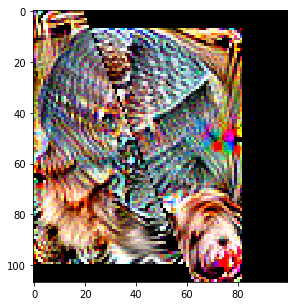

In [239]:
post_proc_adv_patch = image_utils.postprocessing(ex_folded_array[0])

image_utils.show_image(post_proc_adv_patch)

In [ ]:
print("starting point:")
print("x:", my_x1)
print("y:", my_y1)
print("ending point:")
print("x:", my_x2)
print("y:", my_y2)

### New function

In [8]:
# takes as an input ordered start, end points, rotated patches
# returns rotated patches with fold. All empty cells are labeled as -2
# All coordinates are specified from the left-bottom point

@tf.function
def _simple_fold_neightbours(patches, x_start, y_start, x_end, y_end, thickness):
    # add 2
    pathces_plus_2 = tf.add(patches, 2)
    
    # cast variables to float
    x_start_f, y_start_f = tf.cast(x_start, dtype=tf.float32), tf.cast(y_start, dtype=tf.float32)
    x_end_f, y_end_f =  tf.cast(x_end, dtype=tf.float32), tf.cast(y_end, dtype=tf.float32)
    thickness_f = tf.cast(thickness, dtype=tf.float32)
    
    # if a, b are parameters of the line: y = ax + b,
    # find 1/a
    one_div_a = (x_end_f - x_start_f) / (y_end_f - y_start_f) 
    
    # get (x, y) thickness representation
    angle = - tf.math.atan((y_end_f - y_start_f) / (x_end_f - x_start_f))
    projected_x = thickness_f * tf.cos(math.pi/2.0 - angle)
    projected_y = thickness_f * tf.sin(math.pi/2.0 - angle)
    
    # cast variables to int
    projected_x_i = tf.cast(projected_x, dtype=tf.int32)
    projected_y_i = tf.cast(projected_y, dtype=tf.int32)

    # get starting point of right border
    right_border_start = x_start_f + thickness_f / tf.cos(math.pi/2.0 - angle)
    
    # get left border
    left_border = tf.cast(tf.range(x_start_f, x_end_f, delta=-one_div_a, dtype=tf.float32), dtype=tf.int32)
    left_border_appendix = x_end * tf.ones(x_end - tf.shape(left_border), dtype=tf.int32)
    full_size_left_border = tf.concat((left_border, left_border_appendix), 0)
    
    # get right border
    right_border = tf.cast(tf.range(right_border_start, x_end_f, delta=-one_div_a, dtype=tf.float32), dtype=tf.int32)
    right_border_appendix = x_end * tf.ones(x_end - tf.shape(right_border), dtype=tf.int32)
    full_size_right_border = tf.concat((right_border, right_border_appendix), 0)

    # produce left mask
    left_mask = tf.expand_dims(tf.expand_dims(tf.sequence_mask(full_size_left_border, x_end, dtype=tf.float32), 0), 3)
    left_mask_expanded = tf.broadcast_to(left_mask, [tf.shape(patches)[0], x_end, x_end, tf.shape(patches)[3]])
    
    # produce right mask
    right_mask_inverse = tf.expand_dims(tf.expand_dims(tf.sequence_mask(full_size_right_border, x_end, dtype=tf.float32), 
                                                       0), 
                                        3)
    right_mask = tf.math.abs(right_mask_inverse - 1)
    right_mask_expanded = tf.broadcast_to(right_mask, [tf.shape(patches)[0], x_end, x_end, tf.shape(patches)[3]])
    
    # get masked
    left_part = pathces_plus_2 * left_mask_expanded
    right_part = pathces_plus_2 * right_mask_expanded
    
    # shift right part
    half_shifted_right_part = tf.roll(right_part, shift=(-projected_x_i), axis=(2))
    shifted_right_part = tf.roll(half_shifted_right_part, shift=(projected_y_i), axis=(1))
    
    
    # get folded patch
    folded_patch = left_part + shifted_right_part - 2

    return folded_patch
    

In [9]:
@tf.function
def _order_neightbouts(patches, x_start, y_start, x_end, y_end):
    # cast variables to float
    x_start_f, y_start_f = tf.cast(x_start, dtype=tf.float32), tf.cast(y_start, dtype=tf.float32)
    x_end_f, y_end_f =  tf.cast(x_end, dtype=tf.float32), tf.cast(y_end, dtype=tf.float32)
    
    center = tf.cast(tf.shape(patches)[1], dtype=tf.float32) /2
    
    # calculate vector product of start and end ponints with respect
    v_prod = (x_start_f - center) * (y_end_f - center) - (x_end_f - center) * (y_start_f - center)
    
    
    # init returning functions
    def f_x_start(): return x_start
    def f_y_start(): return y_start
    def f_x_end(): return x_end
    def f_y_end(): return y_end
    
    x_start_right_order = tf.cond(v_prod < 0, f_x_start, f_x_end)
    y_start_right_order = tf.cond(v_prod < 0, f_y_start, f_y_end)
    x_end_right_order = tf.cond(v_prod < 0, f_x_end, f_x_start)
    y_end_right_order = tf.cond(v_prod < 0, f_y_end, f_y_start)
    
    return x_start_right_order, y_start_right_order, x_end_right_order, y_end_right_order

In [10]:
# takes as an input unordered start, end points, unrotated patches
# returns unrotated patches with fold. All empty cells are labeled as -2
# All coordinates are specified from the left-bottom point

@tf.function
def _universal_fold_neightbours(patches, x_start, y_start, x_end, y_end, thickness):
    # get the right order of starting and ending points
    x_start_right_order, y_start_right_order, x_end_right_order, y_end_right_order = _order_neightbouts(patches, 
                                                                                                        x_start, 
                                                                                                        y_start, 
                                                                                                        x_end, 
                                                                                                        y_end)

    # rotate functions return rotated_patches, x_start_top, y_start_top, x_end_left, y_end_left, case
    # for positive values rotation rotates counter-clockwise
    def remain(): return patches, x_start_right_order, y_start_right_order, x_end_right_order, y_end_right_order, 0
    def rotate_counter_clockwise_1(): return tf.contrib.image.rotate(patches, math.pi/2), \
                                             tf.shape(patches)[1] - y_start_right_order, \
                                             tf.shape(patches)[2], \
                                             tf.shape(patches)[1], \
                                             x_end_right_order, \
                                             1
    def rotate_counter_clockwise_2(): return tf.contrib.image.rotate(patches, math.pi), \
                                             tf.shape(patches)[1] - x_start_right_order, \
                                             tf.shape(patches)[2], \
                                             tf.shape(patches)[1], \
                                             tf.shape(patches)[2] - y_end_right_order, \
                                             2
    def rotate_counter_clockwise_3(): return tf.contrib.image.rotate(patches, 3*math.pi/2), \
                                             y_start_right_order, \
                                             tf.shape(patches)[2], \
                                             tf.shape(patches)[1], \
                                             tf.shape(patches)[2] - x_end_right_order, \
                                             3
    
    def cases_0_or_2(): return tf.cond(tf.math.equal(y_start_right_order, tf.shape(patches)[1]),
                                       remain,
                                       rotate_counter_clockwise_2)
    
    def cases_1_or_3(): return tf.cond(tf.math.equal(x_start_right_order, tf.shape(patches)[1]),
                                       rotate_counter_clockwise_1,
                                       rotate_counter_clockwise_3)
    
    # rotate
    state = tf.math.logical_or(tf.math.equal(y_start_right_order, 0), tf.math.equal(y_start_right_order, tf.shape(patches)[1]))
    rotated_patches, x_start_top, y_start_top, x_end_left, y_end_left, case = tf.cond(state,
                                                                                      cases_0_or_2,
                                                                                      cases_1_or_3)
    
    # make a fold
    folded_unrotated_patch = _simple_fold_neightbours(rotated_patches, x_start_top, y_start_top, x_end_left, y_end_left, thickness)
    
    # unrotate
    def unrotate_0_or_2(): return tf.cond(tf.math.equal(case, 0),
                                          lambda: tf.contrib.image.rotate(folded_unrotated_patch, 0),
                                          lambda: tf.contrib.image.rotate(folded_unrotated_patch, -math.pi))
    
    def unrotate_1_or_3(): return tf.cond(tf.math.equal(case, 1),
                                          lambda: tf.contrib.image.rotate(folded_unrotated_patch, -math.pi/2),
                                          lambda: tf.contrib.image.rotate(folded_unrotated_patch, -3*math.pi/2))
    
    
    folded_unrotated_patch = tf.cond(tf.math.logical_or(tf.math.equal(case, 0), tf.math.equal(case, 2)),
                                     unrotate_0_or_2,
                                     unrotate_1_or_3)
    
    
    return folded_unrotated_patch
        

In [236]:
# takes as an input ordered start, end points, rotated patches
# it is persumed that start point is on top and end point on the bottom
# returns rotated patches with fold. All empty cells are labeled as -2;
# all coordinates are specified from the left-bottom point

@tf.function
def _simple_fold_counters(patches, x_start, y_start, x_end, y_end, thickness):
    # add 2
    pathces_plus_2 = tf.add(patches, 2)
    
    # cast variables to float
    x_start_f, y_start_f = tf.cast(x_start, dtype=tf.float32), tf.cast(y_start, dtype=tf.float32)
    x_end_f, y_end_f =  tf.cast(x_end, dtype=tf.float32), tf.cast(y_end, dtype=tf.float32)
    thickness_f = tf.cast(thickness, dtype=tf.float32)
    
    # if a, b are parameters of the line: y = ax + b,
    # find 1/a
    one_div_a = (x_end_f - x_start_f) / (y_end_f - y_start_f) 
    
    # get (x, y) thickness representation
    angle = - tf.math.atan((y_end_f - y_start_f) / (x_end_f - x_start_f))
    projected_x = thickness_f * tf.cos(math.pi/2.0 - angle)
    projected_y = thickness_f * tf.sin(math.pi/2.0 - angle)
    
    # cast variables to int
    projected_x_i = tf.cast(projected_x, dtype=tf.int32)
    projected_y_i = tf.cast(projected_y, dtype=tf.int32)
    
    # ==================================== resize patch ===================================== #
   
    # get white space to append patch
    white_space = tf.zeros((tf.shape(patches)[0], 
                            projected_y_i, 
                            tf.shape(patches)[2], 
                            tf.shape(patches)[3]), dtype=tf.float32)

    # expand patch
    def no_patch_expansion(): return pathces_plus_2
    def patch_expansion(): return tf.cond(tf.math.greater(angle, 0),
                                          patch_expand_bottom,
                                          patch_expand_top)
    def patch_expand_top(): return tf.concat((white_space, pathces_plus_2), 1)
    def patch_expand_bottom(): return tf.concat((pathces_plus_2, white_space), 1)
    
    expanded_patch = tf.cond(tf.math.equal(projected_y_i, 0),
                             no_patch_expansion,
                             patch_expansion)

    # =================================== get right border ==================================== #

    # get right border start and end points
    right_border_start = tf.cond(tf.math.greater(x_start_f + thickness_f / tf.cos(math.pi/2.0 - tf.abs(angle)), 
                                                 tf.cast(tf.shape(patches)[2], dtype=tf.float32)),
                                 lambda: tf.cast(tf.shape(patches)[2], dtype=tf.float32),
                                 lambda: x_start_f + thickness_f / tf.cos(math.pi/2.0 - tf.abs(angle)))
    
    right_border_end = tf.cond(tf.math.greater(x_end_f + thickness_f / tf.cos(math.pi/2.0 - tf.abs(angle)), 
                                               tf.cast(tf.shape(patches)[2], dtype=tf.float32)),
                               lambda: tf.cast(tf.shape(patches)[2], dtype=tf.float32),
                               lambda: x_end_f + thickness_f / tf.cos(math.pi/2.0 - tf.abs(angle)))                               
    
    # construct meaningful right border    
    def get_right_border_zero_slope(): return tf.cast(right_border_start, dtype=tf.int32) * tf.ones(tf.shape(patches)[1], dtype=tf.int32)
    def get_right_border_nonzero_slope(): return tf.cast(tf.range(right_border_start, 
                                                                  right_border_end, 
                                                                  delta=-one_div_a, 
                                                                  dtype=tf.float32), 
                                                         dtype=tf.int32)
    
    right_border = tf.cond(tf.math.equal(one_div_a, 0),
                           get_right_border_zero_slope,
                           get_right_border_nonzero_slope)

    # here is a rpoblem
    def no_appendix(): return right_border
    def add_appendix(): return tf.cond(tf.math.greater(x_end_f + thickness_f / tf.cos(math.pi/2.0 - tf.abs(angle)), 
                                                       tf.cast(tf.shape(patches)[2], dtype=tf.float32)),
                                       add_bottom_appendix,
                                       add_top_appendix)
    def add_top_appendix(): return tf.concat((tf.shape(patches)[2] * tf.ones(tf.shape(patches)[2] - tf.shape(right_border), dtype=tf.int32),
                                              right_border), 0)
    def add_bottom_appendix(): return tf.concat((right_border,
                                                 tf.shape(patches)[2] * tf.ones(tf.shape(patches)[2] - tf.shape(right_border), dtype=tf.int32)), 0)
    
    full_size_right_border = tf.cond(tf.math.logical_or(tf.math.greater(x_end_f + thickness_f / tf.cos(math.pi/2.0 - tf.abs(angle)), 
                                                                        tf.cast(tf.shape(patches)[2], dtype=tf.float32)),
                                                       (tf.math.greater(x_start_f + thickness_f / tf.cos(math.pi/2.0 - tf.abs(angle)), 
                                                                        tf.cast(tf.shape(patches)[2], dtype=tf.float32)))),
                                     add_appendix,
                                     no_appendix)
                               
    # expand left border
    def no_right_border_expansion(): return full_size_right_border
    def right_border_expansion(): return tf.cond(tf.math.greater(angle, 0),
                                                 right_border_expand_bottom,
                                                 right_border_expand_top)
    def right_border_expand_top(): return tf.concat((tf.zeros((projected_y_i), dtype=tf.int32),
                                                    full_size_right_border), 0)
    def right_border_expand_bottom(): return tf.concat((full_size_right_border,
                                                        tf.zeros((projected_y_i), dtype=tf.int32)), 0)

                               
                               
    expanded_right_border = tf.cond(tf.math.equal(projected_y_i, 0),
                                    no_right_border_expansion,
                                    right_border_expansion)
    
    # =================================== get left border =================================== #
    
    # construct meaningful left border    
    def get_left_border_zero_slope():return x_start * tf.ones(tf.shape(patches)[1], dtype=tf.int32)
    def get_left_border_nonzero_slope(): return tf.cast(tf.range(x_start_f, 
                                                                 x_end_f, 
                                                                 delta=-one_div_a, 
                                                                 dtype=tf.float32), 
                                                        dtype=tf.int32)
    
    left_border = tf.cond(tf.math.equal(one_div_a, 0),
                          get_left_border_zero_slope,
                          get_left_border_nonzero_slope)
        
    # expand left border
    def no_left_border_expansion(): return left_border
    def left_border_expansion(): return tf.cond(tf.math.greater(angle, 0),
                                                left_border_expand_bottom,
                                                left_border_expand_top)
    def left_border_expand_top(): return tf.concat((tf.zeros((projected_y_i), dtype=tf.int32),
                                                   left_border), 0)
    def left_border_expand_bottom(): return tf.concat((left_border,
                                                       tf.zeros((projected_y_i), dtype=tf.int32)), 0)

                               
                               
                               
    expanded_left_border = tf.cond(tf.math.equal(projected_y_i, 0),
                                   no_left_border_expansion,
                                   left_border_expansion)
    
    # ===================================== produce mask ===================================== #
    
    # produce left mask
    left_mask = tf.expand_dims(tf.expand_dims(tf.sequence_mask(expanded_left_border, 
                                                               tf.shape(patches)[2], 
                                                               dtype=tf.float32), 0), 3)
    
    left_mask_expanded = tf.broadcast_to(left_mask, [tf.shape(expanded_patch)[0],  
                                                     tf.shape(expanded_patch)[1],  
                                                     tf.shape(expanded_patch)[2], 
                                                     tf.shape(expanded_patch)[3]])
    
    # produce right mask
    right_mask_inverse = tf.expand_dims(tf.expand_dims(tf.sequence_mask(expanded_right_border, 
                                                                        tf.shape(patches)[2], 
                                                                        dtype=tf.float32), 0), 3)
    right_mask = tf.math.abs(right_mask_inverse - 1)
    
    right_mask_expanded = tf.broadcast_to(right_mask, [tf.shape(expanded_patch)[0],  
                                                       tf.shape(expanded_patch)[1],  
                                                       tf.shape(expanded_patch)[2], 
                                                       tf.shape(expanded_patch)[3]])    
    
    
    # get masked
    left_part = expanded_patch * left_mask_expanded
    right_part = expanded_patch * right_mask_expanded

    
    # ========================================= shift ======================================== #
    
    def shift_horizontal_only(): return tf.roll(right_part, shift=(-projected_x_i), axis=(2))
    def shift_horizontal_and_vertical(): return tf.cond(tf.math.less(angle, 0),
                                                        shift_left_and_top,
                                                        shift_left_and_bottom)
    def shift_left_and_top(): return tf.roll(right_part, shift=(projected_x_i, -projected_y_i), axis=(2, 1))
    def shift_left_and_bottom(): return tf.roll(right_part, shift=(-projected_x_i, projected_y_i), axis=(2, 1))
    
    shifted_right_part = tf.cond(tf.math.equal(projected_y_i, 0),
                                 shift_horizontal_only,
                                 shift_horizontal_and_vertical)
    
    
    
    # ====================================== apply mask ====================================== #
    
     # get folded patch
    folded_patch = left_part + shifted_right_part - 2

    return folded_patch

In [ ]:
def _universal_fold(patches, x_start, y_start, x_end, y_end, thickness):
    # rotate functions return rotated_patches, x_start_top, y_start_top, x_end_left, y_end_left, case
    # for positive values rotation rotates counter-clockwise
    def remain(): return 0
    def rotate_counter_clockwise_1(): return 0
    def rotate_counter_clockwise_2(): return 0
    def rotate_counter_clockwise_3(): return 0
    
    
    rotated_patches, x_start_top, y_start_top, x_end_left, y_end_left, case = tf.cond(tf.math.logical_or(tf.math.equal(y_start)),
                                                                                      cases_0_or_2,
                                                                                      cases_1_or_3)

    
    # unrotate
    def unrotate_0_or_2(): return 0
        
    def unrotate_0_or_2(): return 0
    

In [ ]:
def make_fold(patches, x_start, y_start, x_end, y_end, thickness):
    pass